## Automatic detection of identity hate

In [1]:
"""
Created on Fri Feb  2 20:43:14 2018

@author: Felipe Lopez
"""

# Read necessary libraries
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
stopword = set(STOPWORDS) # Get list of stop words (e.g., the, is, are)

# Set display options
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [2]:
# Data wrangling
# First stage: Use Kaggle dataset of Wikipedia corpus (in English)
df = pd.read_csv('train/train.csv')
df.drop('id', axis = 1, inplace = True)
print(df.columns)
#print(df.head(20))
# Next stage: Scrape own data from YouTube, Univision, UWD, DRM

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], dtype='object')


## First Plot:

### Wordcloud of frequent n-grams

Number of hate speech messages :
159571


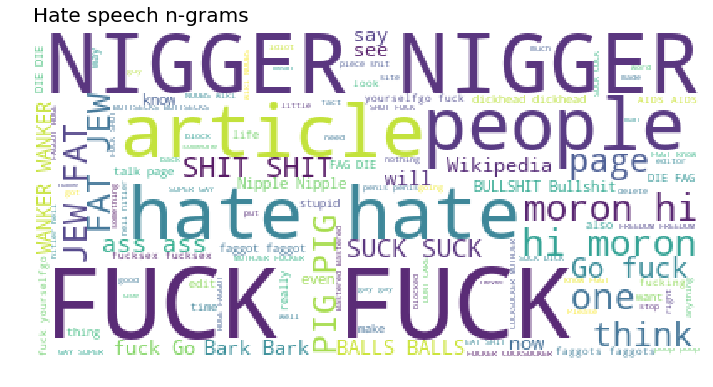

In [3]:
# Extract toxic data
id_hate = df[ df['toxic'] == 1 ]
# Print number of hate speech messages
print('Number of hate speech messages :')
print(len(df['toxic']))
wc = WordCloud(background_color = 'white', max_words = 2000, stopwords = stopword).generate(' '.join(id_hate.comment_text.values))
plt.axis('off')
plt.title('Hate speech n-grams', loc = 'left', fontdict = {'fontsize': 20})
plt.imshow(wc.recolor(random_state=123), alpha=0.9)
plt.gcf().set_size_inches(12,8)
plt.show()
# The result is clear and very rich. There are very offensive terms but also repeated words, usernames, and non-offensive words

In [4]:
# Show hate speech messages
print(id_hate.head(20))

                                          comment_text  toxic  severe_toxic  obscene  threat  insult  identity_hate
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1             1        1       0       1              0
12   Hey... what is it..\n@ | talk .\nWhat is it......      1             0        0       0       0              0
16   Bye! \n\nDon't look, come or think of comming ...      1             0        0       0       0              0
42   You are gay or antisemmitian? \n\nArchangel WH...      1             0        1       0       1              1
43            FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!      1             0        1       0       1              0
44   I'm Sorry \n\nI'm sorry I screwed around with ...      1             0        0       0       0              0
51   GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK T...      1             0        1       0       0              0
55   Stupid peace of shit stop deleting my stuff as...      1           

In [5]:
# Select features to train a model
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = df['comment_text']
y = df['toxic']

C:\Users\felip\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
# Divide data in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

# Count vectorizer: Detect features with 1-grams and 2-grams
max_features = 50000
vec = CountVectorizer(max_features = max_features, ngram_range = (1,2), stop_words = 'english')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Transforming words into feature vectors
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Convert the raw document to a matrix of TF-IDF features
vec_tfid = TfidfVectorizer(ngram_range = (1,2), tokenizer = tokenize,
               min_df = 3, strip_accents = 'unicode', use_idf = 1,
               smooth_idf = 1, sublinear_tf = 1, max_features = max_features)
# Extract the document-term matrix
X_train_vec = vec_tfid.fit_transform(X_train)
# Transform testing data (using fitted vocabulary) into a document-term matrix
X_test_vec = vec_tfid.transform(X_test)

In [7]:
# Import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
# Train the model using training document-train matrix
nb.fit(X_train_vec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [8]:
# Use the model to make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_vec)
# Calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.94821146567066905

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     35996
          1       0.91      0.52      0.66      3897

avg / total       0.95      0.95      0.94     39893



In [10]:
# Print the confusion matrix
conf_arr = metrics.confusion_matrix(y_test, y_pred_class)
print(conf_arr)

[[35797   199]
 [ 1867  2030]]


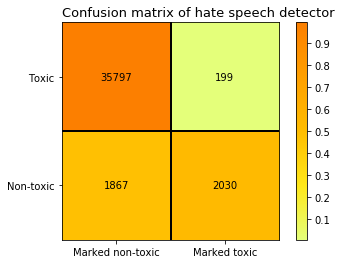

In [11]:
## Second Plot:
# Plot confusion matrix of classifier

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.get_cmap('Wistia'), 
                interpolation='nearest')

# Label entries of confusion matrix
for x in range(2):
    for y in range(2):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res, ticks = np.linspace(0,1.0,11))
plt.xticks(range(2), ['Marked non-toxic', 'Marked toxic'])
plt.yticks(range(2), ['Toxic', 'Non-toxic'])
plt.title('Confusion matrix of hate speech detector', loc = 'left', fontdict = {'fontsize': 13})
plt.axhline(y=0.5, color = 'black', linewidth = 2.0)
plt.axvline(x=0.5, color = 'black', linewidth = 2.0)
plt.show()